In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
data = pd.read_csv("/content/movie_rate_prediction.zip", encoding='ISO-8859-1')
data.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [26]:
def dataoverview (df,message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

dataoverview(data, 'Overview of the training dataset')


Overview of the training dataset:

Rows: 5851

Number of features: 10

Features:
['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

Missing values: 387

Unique values:
Name        5570
Year          91
Duration     178
Genre        393
Rating        83
Votes       2030
Director    2549
Actor 1     2046
Actor 2     2373
Actor 3     2572
dtype: int64


In [27]:
data.isna().sum()

Name          0
Year          0
Duration      0
Genre        31
Rating        0
Votes         0
Director      1
Actor 1      75
Actor 2     117
Actor 3     163
dtype: int64

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5851 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5851 non-null   object 
 1   Year      5851 non-null   int64  
 2   Duration  5851 non-null   int64  
 3   Genre     5820 non-null   object 
 4   Rating    5851 non-null   float64
 5   Votes     5851 non-null   int64  
 6   Director  5850 non-null   object 
 7   Actor 1   5776 non-null   object 
 8   Actor 2   5734 non-null   object 
 9   Actor 3   5688 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 502.8+ KB


In [28]:
data['Genre'].value_counts()

Genre
Drama                       870
Drama, Romance              334
Action, Crime, Drama        329
Action, Drama               207
Comedy, Drama               206
                           ... 
History, Romance              1
Drama, History, Sport         1
Animation, Comedy, Drama      1
Family, Drama, Thriller       1
Romance, Musical, Drama       1
Name: count, Length: 393, dtype: int64

In [30]:
data['Director'].value_counts()

Director
David Dhawan            41
Mahesh Bhatt            39
Ram Gopal Varma         34
Shakti Samanta          34
Hrishikesh Mukherjee    33
                        ..
Dayanand                 1
Santosh Kashyap          1
Manav Kaul               1
Sajeev Balath            1
Mozez Singh              1
Name: count, Length: 2549, dtype: int64

In [31]:
data.head(10)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
9,@Andheri,2014,116,"Action, Crime, Thriller",4.0,11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon
10,1:1.6 An Ode to Lost Love,2004,96,Drama,6.2,17,Madhu Ambat,Rati Agnihotri,Gulshan Grover,Atul Kulkarni
11,1:13:7 Ek Tera Saath,2016,120,Horror,5.9,59,Arshad Siddiqui,Pankaj Berry,Anubhav Dhir,Hritu Dudani
12,100 Days,1991,161,"Horror, Romance, Thriller",6.5,983,Partho Ghosh,Jackie Shroff,Madhuri Dixit,Javed Jaffrey
13,100% Love,2012,166,"Comedy, Drama, Romance",5.7,512,Rabi Kinagi,Jeet,Koyel Mallick,Sujoy Ghosh


In [13]:
# As we are going to predict movie ratings based on fdf.dropna(subset=['Name','Year','Duration','Votes','Rating'],inplace=True)eatures, we need to remove null values from features that can directly influence the results.
data.dropna(subset=['Name','Year','Duration','Votes','Rating'],inplace=True)
data.isna().sum()

Name          0
Year          0
Duration      0
Genre        31
Rating        0
Votes         0
Director      1
Actor 1      75
Actor 2     117
Actor 3     163
dtype: int64

In [14]:
# Remove parentheses from 'Year' column and convert to integer
data['Year'] = data['Year'].str.strip('()').astype(int)
# Remove commas from 'Votes' column and convert to integer
data['Votes'] = data['Votes'].str.replace(',', '').astype(int)
# Remove min from 'Duration' column andDurationonvert to integer
data['Duration'] = data['Duration'].str.replace('min', '').astype(int)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5851 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5851 non-null   object 
 1   Year      5851 non-null   int64  
 2   Duration  5851 non-null   int64  
 3   Genre     5820 non-null   object 
 4   Rating    5851 non-null   float64
 5   Votes     5851 non-null   int64  
 6   Director  5850 non-null   object 
 7   Actor 1   5776 non-null   object 
 8   Actor 2   5734 non-null   object 
 9   Actor 3   5688 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 502.8+ KB


In [33]:
data.describe()

,Year,Duration,Rating,Votes
count,5851.000000,5851.000000,5851.000000,5851.000000
mean,1996.416852,132.294480,5.931875,2611.273116
std,19.914640,26.555826,1.389942,13433.828528
min,1931.000000,21.000000,1.100000,5.000000
25%,1983.000000,117.000000,5.000000,28.000000
50%,2002.000000,134.000000,6.100000,119.000000
75%,2013.000000,150.000000,7.000000,862.500000
max,2021.000000,321.000000,10.000000,591417.000000


In [34]:
# Drop Genre column
data.drop('Genre',axis=1,inplace=True)


In [35]:
data.head()

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Duration'}>],
       [<Axes: title={'center': 'Rating'}>,
        <Axes: title={'center': 'Votes'}>]], dtype=object)

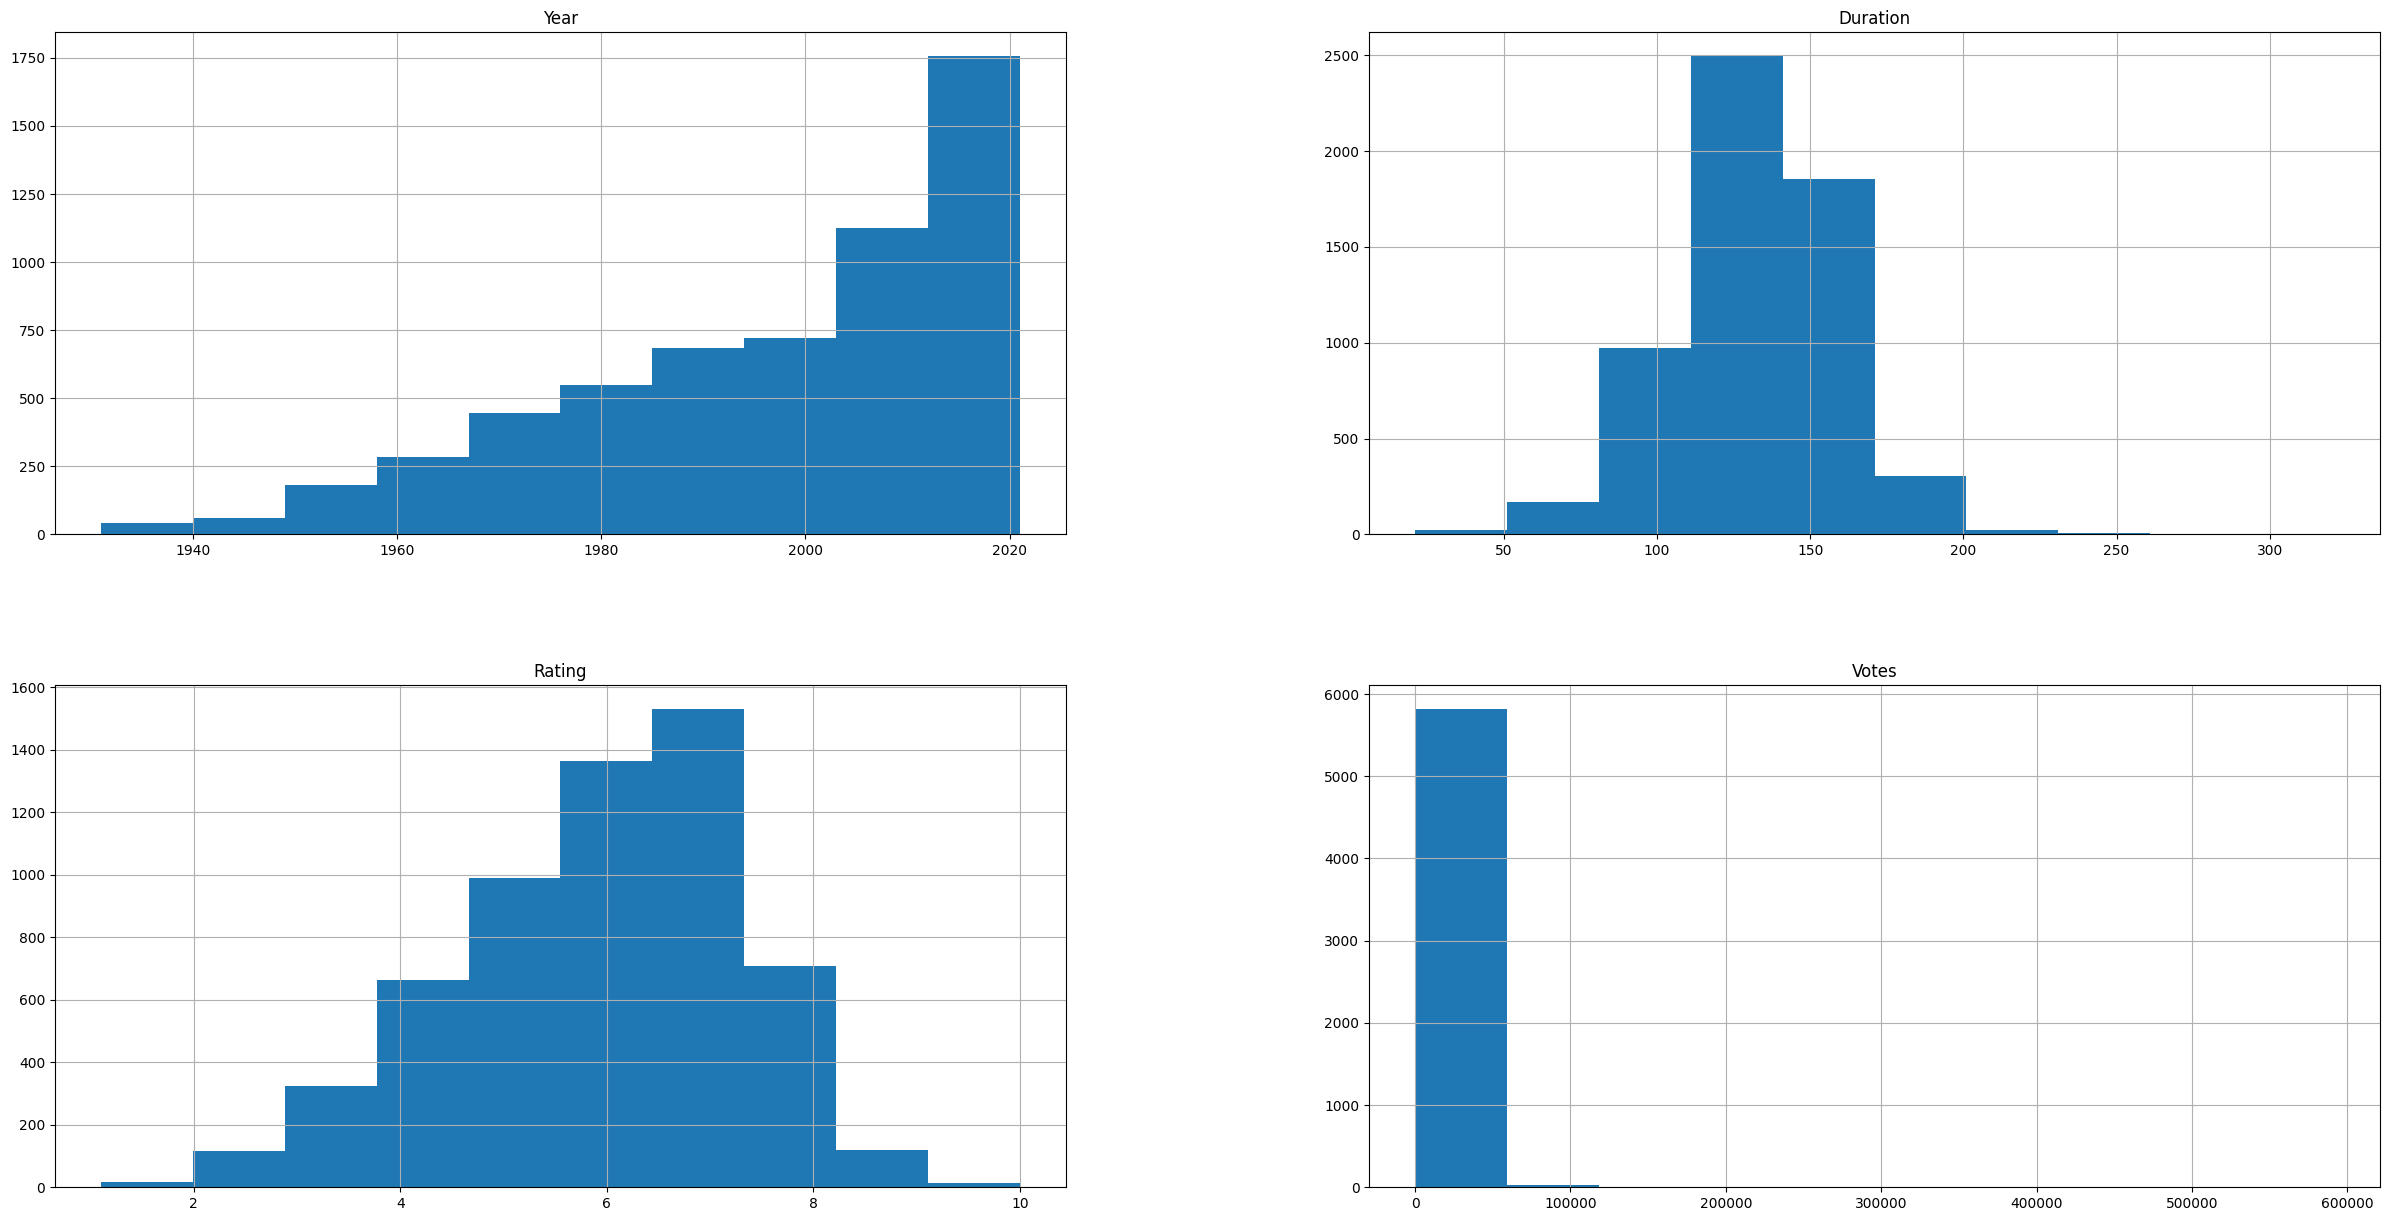

In [36]:
data.hist(figsize=(30,15))


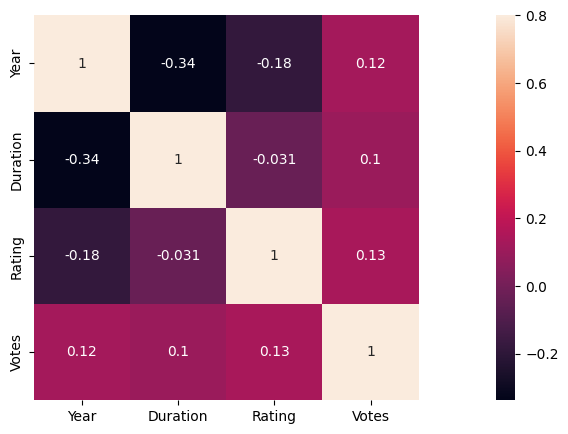

In [37]:
# Heatmap
corrmat = data.corr(numeric_only=True)
fig = plt.figure(figsize=(20,5))

sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.show()

In [38]:
data.head()

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [39]:
data.drop(['Name','Director','Actor 1','Actor 2','Actor 3'], axis=1,inplace=True)
data.head()

,Year,Duration,Rating,Votes
1,2019,109,7.0,8
3,2019,110,4.4,35
5,1997,147,4.7,827
6,2005,142,7.4,1086
8,2012,82,5.6,326


In [15]:

X = data[['Year','Duration','Votes']]
y = data['Rating']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1000)

In [17]:
# Create a pipeline with standard scaling and SGD regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=10000, random_state=1000))
])

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDRegressor(max_iter=10000, random_state=1000))])

In [19]:
# Predict ratings on the test set
y_pred_pipeline = pipeline.predict(X_test)

In [40]:
# Evaluation Metrics for the Pipeline
mab_pipeline = mean_absolute_error(y_test, y_pred_pipeline)
mse_pipeline = mean_squared_error(y_test, y_pred_pipeline)
r2_pipeline = r2_score(y_test, y_pred_pipeline)

In [41]:
print("Pipeline Mean Absolute Error:", mab_pipeline)
print("Pipeline Mean Squared Error:", mse_pipeline)
print("Pipeline R-squared:", r2_pipeline)

Pipeline Mean Absolute Error: 1.040142363499226
Pipeline Mean Squared Error: 1.75589466147756
Pipeline R-squared: 0.037929023872087186


In [42]:
# Take new user input for prediction
new_input = pd.DataFrame({
    'Year': [2021],
    'Duration': [100],
    'Votes': [900],
})

# Use the trained pipeline to make predictions on the input
predicted_rating = pipeline.predict(new_input)

print("Predicted Rating:", predicted_rating)

Predicted Rating: [5.70233089]
